# DATA 410 - Lecture 2

<font face="Chalkboard" color="darkgreen" size=10> Locally Weighted Linear Regression</font>


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

https://towardsdatascience.com/loess-373d43b03564

https://xavierbourretsicotte.github.io/loess.html

The main idea of linear regression is the assumption that:

$$\large y = X\cdot\beta +\sigma\epsilon $$

If we pre-multiply this equation with a matrix of weights (the "weights" are on the main diagonal and the rest of the elements are 0) we get:

$$\large Wy = WX\cdot\beta +\sigma W\epsilon $$


In [ ]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



The following animations are from the scikit-lego documentation:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1bQmo-j35etyEWt7Ce8TSo01YSOhZQBeY'width='800px'/>
<figcaption>Example of how weights work</figcaption></center>
</figure>


<figure>
<center>
<img src='https://drive.google.com/uc?id=19cIIGCSePtJbGVgRT6uWhcV2tNJKe9WG'width='800px'/>
<figcaption>Example of how locally weighted regression works</figcaption></center>
</figure>



In [ ]:
# This definition would NOT work because it is not vectorized (it can only be applied to numbers but not entire vectors)
def tricubic_wt(x):
  if np.abs(x) < 1:
    return (1-np.abs(x)**3)**3
  else:
    return 0.0

In [ ]:
# this is the correct vectorized version
def tricubic_wt(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)         

In [ ]:
tricubic_wt([0.8,0.2,0.1,1.7])

array([0.11621427, 0.97619149, 0.997003  , 0.        ])

Here we have the graph of the weight function.

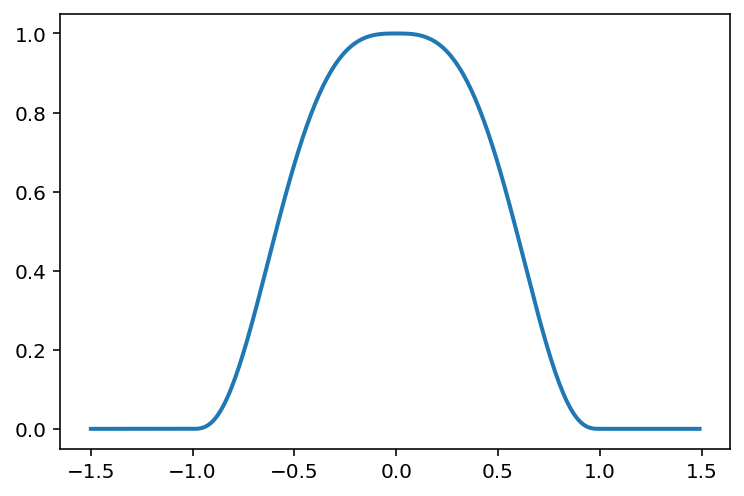

In [ ]:
x = np.arange(-1.5,1.5,0.01)
y = tricubic_wt(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

In [ ]:
import pandas as pd
from math import ceil
from scipy import linalg
from IPython.display import Image
from IPython.display import display
plt.style.use('seaborn-white')

In [ ]:
#Defining the bell shaped kernel function - used for plotting later on
def kernel_function(xi,x0,tau= .005): 
    return np.exp( - (xi - x0)**2/(2*tau)   )

def lowess_bell_shape_kern(x, y, tau = .005):
    """lowess_bell_shape_kern(x, y, tau = .005) -> yest
    Locally weighted regression: fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The kernel function is the bell shaped function with parameter tau. Larger tau will result in a
    smoother curve. 
    """
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([np.exp(- (x - x[i])**2/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

In [ ]:
def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

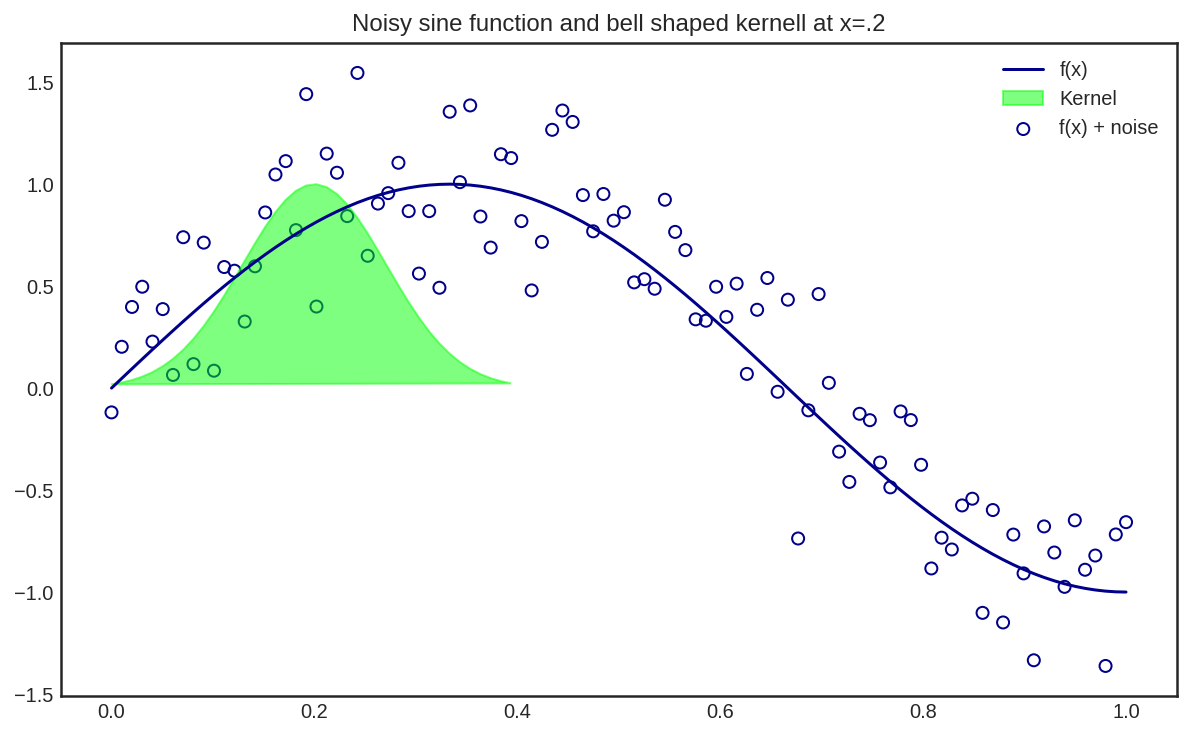

In [ ]:
#Initializing noisy non linear data
x = np.linspace(0,1,100)
noise = np.random.normal(loc = 0, scale = .25, size = 100)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = y + noise

#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,.005), color = 'lime', alpha = .5, label = 'Kernel')
plt.legend()
plt.title('Noisy sine function and bell shaped kernell at x=.2')
plt.show()

In [ ]:
f = 0.25
yest = lowess_ag(x, y, f=f, iter=3)
yest_bell = lowess_bell_shape_kern(x,y)

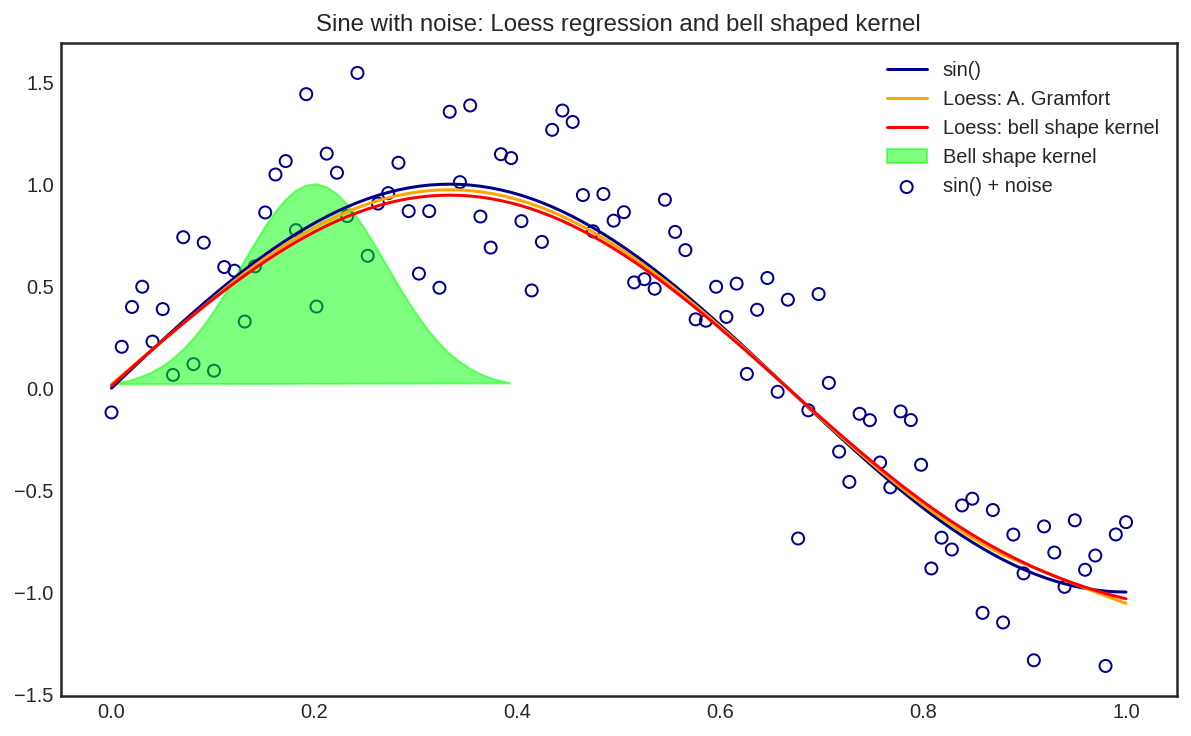

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'sin()')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,.005), color = 'lime', alpha = .5, label = 'Bell shape kernel')
plt.plot(x,yest,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x,yest_bell,color = 'red', label = 'Loess: bell shape kernel')
plt.legend()
plt.title('Sine with noise: Loess regression and bell shaped kernel')
plt.show()